## Problem: 


 Train a Wasserstein GAN with gradient penalty on the AFHQ dataset. Plot the loss curves for the Generator and Critic networks. Plot a 10 by 10 grid of images for generated images for each class. Compute the class conditional FID for all three classes taking 1000 real and generated images. Plot the generated images obtained via linear interpolation of between a pair of latent vectors. 




In [1]:
import warnings
warnings.filterwarnings('ignore')


import time

def seconds_to_hms(seconds):
    # Convert seconds to hours, minutes, and seconds
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)

    # Return formatted string
    return "%d hr:%02d min:%02d sec" % (h, m, s)


In [2]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision
from torchvision.utils import save_image
import torchvision.utils as vutils
from torchvision import transforms


import os
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import random



In [3]:
class AnimalFacesDataset(datasets.VisionDataset):
    def __init__(self, root, transform=None, target_transform=None, train=True):
        super(AnimalFacesDataset, self).__init__(root, transform=transform, target_transform=target_transform)
        self.train = train
        path = root  # Use root directly without appending 'train' or 'val'
        
        self.data = []
        self.targets = []
        self.classes = ['cat', 'dog', 'wild']
        self.class_to_idx = {'cat': 0, 'dog': 1, 'wild': 2}
        self.class_counts = {class_name: 0 for class_name in self.classes}
        
        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(path, class_name)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                self.data.append(img_path)
                self.targets.append(label)
                self.class_counts[class_name] += 1  # Update class count
        
    def __getitem__(self, index):
        img_path, target = self.data[index], self.targets[index]
        img = Image.open(img_path).convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img, target
    
    def __len__(self):
        return len(self.data)
    
    def get_class_counts(self):
        return self.class_counts

In [4]:


# Hyperparameters 

# Define number of workers and GPUs
# More workers can increase the throughput of the data loading process and improve training time 
NUM_WORKERS = 2  # how many subprocesses to use for data loading. 

# Define the number of channels in the image: 3 for RGB
CHANNELS_IMG = 3
IMAGE_SIZE = 128 # input image resolution


LEARNING_RATE = 0.0001  #1e-4  # WGAN recommendation
BATCH_SIZE = 64  # WGAN-GP paper recommendation
FEATURES_CRITIC = 128  # ncf
FEATURES_GEN = 128   # ngf

# WGAN-GP
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

Z_DIM = 100  # nz or NOISE_DIM 


# Adam  : WGAN-GP recommendation
BETA1 = 0.0  # momentum term
BETA2 = 0.9   # exponential average



NUM_EPOCHS = 100  




In [5]:

# Normalization :
# Centering the Data: It centers the data around zero, which can help with the stability of training.
# Matching Generator Output: It matches the range of the generator's tanh output.
# Consistency: It ensures that both real and generated images are treated consistently by the discriminator/critic




# Transforms
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)] # mean of 0.5 and a standard deviation of 0.5. 
    ),
])



train_dataset = AnimalFacesDataset(root='afhq/train', transform=transform, train=True)
val_dataset = AnimalFacesDataset(root='afhq/val', transform=transform, train=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)



print(f'Train data samples: ', len(train_dataset))
print(f'Validation data samples: ', len(val_dataset))


# Printing each class size with class names for training dataset
train_class_counts = train_dataset.get_class_counts()
for class_name, count in train_class_counts.items():
    print(f"Training samples for class {class_name}: {count}")

# Printing each class size with class names for validation dataset
val_class_counts = val_dataset.get_class_counts()
for class_name, count in val_class_counts.items():
    print(f"Validation samples for class {class_name}: {count}")

Train data samples:  14630
Validation data samples:  1500
Training samples for class cat: 5153
Training samples for class dog: 4739
Training samples for class wild: 4738
Validation samples for class cat: 500
Validation samples for class dog: 500
Validation samples for class wild: 500


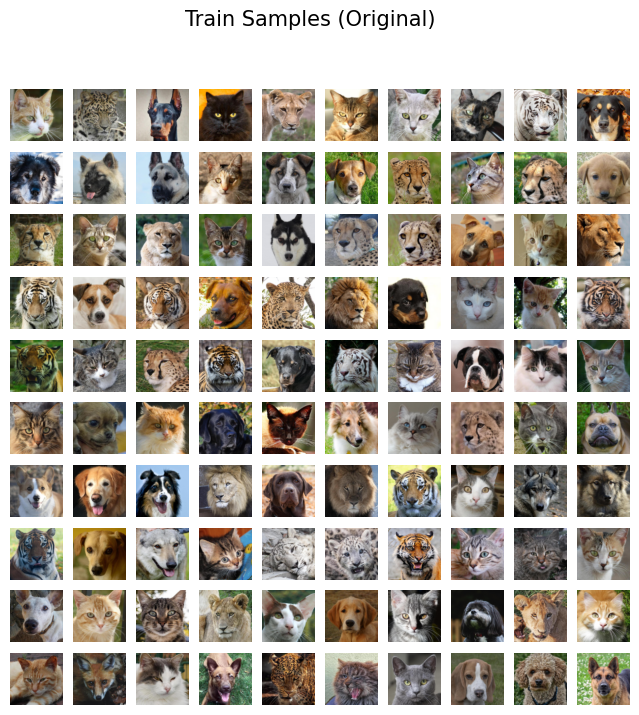

In [6]:


def imshow(img):
    # Denormalize the image
    img = img * 0.5 + 0.5  # This will bring your image range to [0..1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # No axes for a cleaner image


# Randomly sample 100 images from train_dataset
random_indices = random.sample(range(len(train_dataset)), 100)
random_images = [train_dataset[i][0] for i in random_indices]

# Plot images in a grid
fig = plt.figure(figsize=(8, 8))
for idx, img in enumerate(random_images):
    ax = fig.add_subplot(10, 10, idx + 1, xticks=[], yticks=[])
    imshow(img)

# Add title to the figure
fig.suptitle("Train Samples (Original)", fontsize=15)


plt.show()


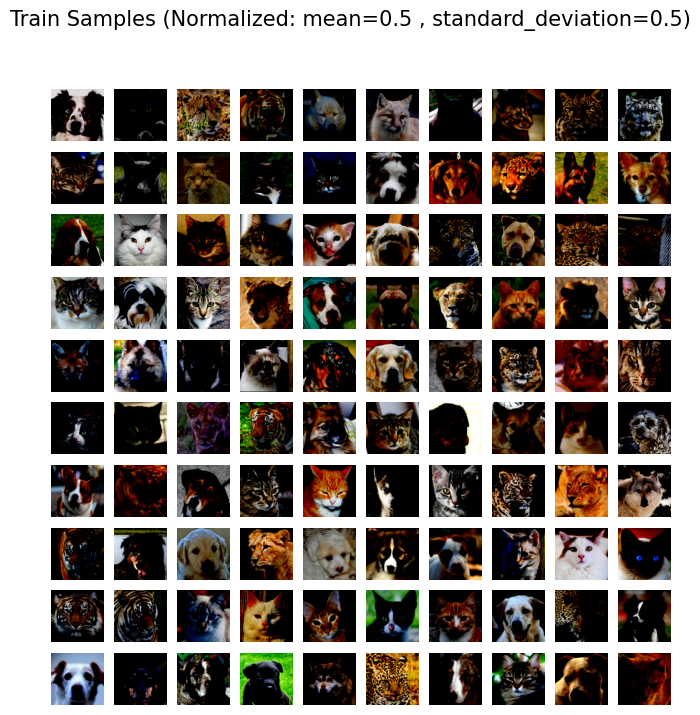

In [7]:


def imshow(img):
    # Convert from tensor image
    img = img.numpy().transpose((1, 2, 0))
    # Clip the image data to ensure it is within the valid range
    # This is a quick fix; a better approach might be actual min-max normalization as shown below
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')  # Hide the axes ticks and numbers


# Randomly sample 100 images from train_dataset
random_indices = random.sample(range(len(train_dataset)), 100)
random_images = [train_dataset[i][0] for i in random_indices]

# Plot images in a grid
fig = plt.figure(figsize=(8, 8))
for idx, img in enumerate(random_images):
    ax = fig.add_subplot(10, 10, idx + 1, xticks=[], yticks=[])
    imshow(img)

# Add title to the figure
fig.suptitle("Train Samples (Normalized: mean=0.5 , standard_deviation=0.5)", fontsize=15)

plt.show()


In [8]:
# WGAN : Modify DCGAN architecture with input image size 128x128
## Modifications are commented.

class Critic(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Critic, self).__init__()
        # Additional layer for 128x128 images
        self.critic = nn.Sequential(
            # input: N x channels_img x 128 x 128
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            # Now image is 64x64
            self._block(features_d, features_d * 2, 4, 2, 1),
            # Now image is 32x32
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            # Now image is 16x16
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # Now image is 8x8
            self._block(features_d * 8, features_d * 16, 4, 2, 1),
            # Now image is 4x4
            nn.Conv2d(features_d * 16, 1, kernel_size=4, stride=2, padding=0),
            # Now image is 1x1
             # last layer, no BatchNorm
            
            #nn.Sigmoid(),    # No Sigmoid for WGAN as we are performing classification   # Modify
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            
            #  Avoid batch normalization in the critic to prevent issues related to the Lipschitz constraint,
            #which might alter the distances between samples in a non-uniform way, thus affecting the Lipschitz continuity.
            #nn.BatchNorm2d(out_channels), 
            
            ## NOTE:
#             Use Cases:
#                 LayerNorm: Used in recurrent neural networks and transformers.
#                 InstanceNorm: Often used in style transfer applications within CNNs.

#             Normalization across:
#                 LayerNorm: Normalizes across the feature dimensions for a single sample.
#                 InstanceNorm: Normalizes across spatial dimensions for each feature map and each sample.

#             Dependency on batch size:
#                 LayerNorm: Does not depend on batch size.
#                 InstanceNorm: Does not depend on batch size either, treats each sample independently.
            
            nn.InstanceNorm2d(out_channels, affine=True),    # Modify
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.critic(x)

class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),   # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),   # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),   # img: 32x32
            # Additional layer for 128x128 images
            self._block(features_g * 2, features_g, 4, 2, 1),       # img: 64x64
            nn.ConvTranspose2d(features_g, channels_img, kernel_size=4, stride=2, padding=1), # img: 128x128
            nn.Tanh()  # Output: N x channels_img x 128 x 128
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


            
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif isinstance(m, nn.InstanceNorm2d):  # used in Critic for WGAN
            if m.affine:
                nn.init.normal_(m.weight.data, 1.0, 0.02)
                nn.init.constant_(m.bias.data, 0)
            
            

def test():
    N, in_channels, H, W = 128, 3, 128, 128  # Adjusted for 128x128 images, N: batch_size
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    critic = Critic(in_channels, 64)
    initialize_weights(critic)
    assert critic(x).shape == (N, 1, 1, 1), "Critic test failed"
    gen = Generator(noise_dim, in_channels, 64)
    initialize_weights(gen)
    z = torch.randn((N, noise_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"
    print("Success, tests passed!")

if __name__ == "__main__":
    test()


Success, tests passed!


In [9]:
# Test and display WGAN architecture

# Instantiate the generator and critic
nz = 100  # Size of z latent vector (i.e., size of generator input)
ngf = 64  # Size of feature maps in generator
nc = 3    # Number of channels in the training images. For color images this is 3
ncf = 64  # Size of feature maps in critic

# Create the generator and discriminator
gen = Generator(nz, nc, ngf)
critic = Critic(nc, ncf)



# Apply the weights initialization function to the models
initialize_weights(gen)
initialize_weights(critic)

print(gen, critic)    
    

Generator(
  (net): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): Sequential(
      (0): C

In [10]:
# WGAN with Gradient Penalty (WGAN-GP)


def gradient_penalty(critic, real, fake, device):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty



In [11]:

# Specify the GPUs you want to use
gpu_ids = [3, 5]
available_gpu_ids = list(range(torch.cuda.device_count()))

# Check if the specified GPUs are in the list of available GPUs
if not all(gpu in available_gpu_ids for gpu in gpu_ids):
    raise ValueError("One or more GPU ids specified are not available.")

# Assuming that the first GPU in the list will be the primary one
torch.cuda.set_device(gpu_ids[0])
device = torch.device(f"cuda:{gpu_ids[0]}" if torch.cuda.is_available() else "cpu")  

netG = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
netC = Critic(CHANNELS_IMG, FEATURES_CRITIC).to(device)

# Initialize weights function
initialize_weights(netG)
initialize_weights(netC)

# Wrap the generator and the discriminator in DataParallel with specific GPUs
if len(gpu_ids) > 1:
    print("Using GPUs:", gpu_ids)
    netG = nn.DataParallel(netG, device_ids=gpu_ids)
    netC = nn.DataParallel(netC, device_ids=gpu_ids)



# Setup Adam optimizers for both G and D
optimizerC = optim.Adam(netC.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
optimizerG = optim.Adam(netG.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))



# Create batch of latent vectors that we will use to visualize the progression of the generator
#fixed_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)

print(f"Primary device (parameters): {device}")


Using GPUs: [3, 5]
Primary device (parameters): cuda:3


#  Training WGAN-GP

In [12]:

# Directory setup: Define directories for saving single and multiple images
image_dir = "wgan-gp_AFHQ_generated_images"
os.makedirs(image_dir, exist_ok=True)
single_image_dir = os.path.join(image_dir, 'single_images')
multiple_image_dir = os.path.join(image_dir, 'multiple_images')
os.makedirs(single_image_dir, exist_ok=True)
os.makedirs(multiple_image_dir, exist_ok=True)

In [13]:


# Lists to hold average batch losses and average Wasserstein distances across across all epochs
avg_loss_critic_epoch_list = []
avg_loss_gen_epoch_list = []
avg_wasserstein_distance_epoch_list = []


# Define a fixed set of noise vectors before the training loop starts
# This will be used to generate the same set of images over time
num_images_grid = 100  # 10x10 images
fixed_noise_for_evaluation = torch.randn(num_images_grid, Z_DIM, 1, 1, device=device)  


print("Starting Training WGAN-GP...\n")
start_time = time.time()  # Start time for total training time calculation
for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()  # Start time for the epoch
    
    # Initialize lists for tracking statistics for each epoch: Reset the lists at the beginning of each epoch (per batch)
    loss_critic_list = []
    loss_gen_list = []
    wasserstein_distance_list = []

    
    for batch_id, (real, _) in enumerate(train_loader):  # Target labels not needed! : unsupervised
        real = real.to(device)  #shape (128x3x128x128)
        curr_batch_size = real.shape[0]  # dynamically calculate batch_size as last batch is smaller than 128(BATCH_SIZE).
        #curr_batch_size = real.size(0)
        


        
        # Train Critic: max E[critic(real)] - E[critic(fake)]
        # equivalent to minimizing the negative of that
        wasserstein_distance_batch_sum = 0  # Reset sum of Wasserstein distances for each batch
        for _ in range(CRITIC_ITERATIONS):
            netC.zero_grad() #     # Reset gradients for the critic
            noise = torch.randn(curr_batch_size, Z_DIM, 1, 1).to(device)
            fake = netG(noise)
            
            critic_real = netC(real).reshape(-1)
            critic_fake = netC(fake.detach() ).reshape(-1) # Detach to prevent gradients from flowing into generator
            
            gp = gradient_penalty(netC, real, fake, device=device) # Calculate the gradient penalty
            wasserstein_distance = torch.mean(critic_real) - torch.mean(critic_fake) # Wasserstein loss for the critic

            # Total critic loss, with gradient penalty to enforce a soft version of the Lipschitz constraint. 
            loss_critic = -(wasserstein_distance) + LAMBDA_GP * gp
#             loss_critic = (
#                 -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
#             )
            loss_critic.backward(retain_graph=True)
            optimizerC.step()
        
        # Sum the Wasserstein distance for the current batch
            wasserstein_distance_batch_sum += wasserstein_distance.item()

        # Average Wasserstein distance for the batch after CRITIC_ITERATIONS
        avg_wasserstein_distance = wasserstein_distance_batch_sum / CRITIC_ITERATIONS
        wasserstein_distance_list.append(avg_wasserstein_distance)  # Append 

        
        
        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        netG.zero_grad()
        gen_fake = netC(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        loss_gen.backward()
        optimizerG.step()
        
        # Append critic and gen losses to lists
        loss_critic_list.append(loss_critic.item())
        loss_gen_list.append(loss_gen.item())


        # Print losses and Wasserstein distance occasionally
        if batch_id % 64 == 0:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] (Batch {batch_id+1}/{len(train_loader)}) \t"
                  f"CRITIC loss: {loss_critic:.4f}, GEN loss: {loss_gen:.4f}, "
                  f"Wasserstein Dist: {avg_wasserstein_distance:.4f}")
   

    
    
    # End of epoch - Calculate average loss and Wasserstein distance for the epoch
    avg_loss_critic_epoch = sum(loss_critic_list) / len(loss_critic_list)
    avg_loss_gen_epoch = sum(loss_gen_list) / len(loss_gen_list)
    avg_wasserstein_distance_epoch = sum(wasserstein_distance_list) / len(wasserstein_distance_list)

    avg_loss_critic_epoch_list.append(avg_loss_critic_epoch)
    avg_loss_gen_epoch_list.append(avg_loss_gen_epoch)
    avg_wasserstein_distance_epoch_list.append(avg_wasserstein_distance_epoch)




    # Print average stats at the end of the epoch
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    print(f'Epoch {epoch+1}/{NUM_EPOCHS} completed in {epoch_duration:.4f} secs:\t'
          f'Avg Loss CRITIC: {avg_loss_critic_epoch:.4f}, Avg Loss GEN: {avg_loss_gen_epoch:.4f}, '
          f"Avg Wasserstein Dist: {avg_wasserstein_distance_epoch:.4f}\n\n")


          

    # Periodic evaluation and image saving every 10 epochs
    if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == NUM_EPOCHS - 1:

        with torch.no_grad():
            # Generate a batch of fake images using the fixed noise
            netG.eval()
            fake_fixed = netG(fixed_noise_for_evaluation).detach().cpu()  # forward propagation
            

            # Save single image
            single_image = torchvision.utils.make_grid(fake_fixed[:1], normalize=True)
            torchvision.utils.save_image(single_image, os.path.join(single_image_dir, f"single_fake_{epoch+1:04d}.png"))

            # Save grid of images (10x10)
            grid_images = torchvision.utils.make_grid(fake_fixed[:100], nrow=10, normalize=True)
            torchvision.utils.save_image(grid_images, os.path.join(multiple_image_dir, f"multiple_fake_{epoch+1:04d}.png"))

        netG.train()  # Back to train mode
            

# Training time    
end_time = time.time()
training_time = end_time - start_time
print(f"Total Training time(seconds): {training_time:.2f} seconds")
print(f"Total Training time: {seconds_to_hms(training_time)}")

print('\n')

Starting Training WGAN-GP...

Epoch [1/100] (Batch 1/229) 	CRITIC loss: 4163.9976, GEN loss: 2.9622, Wasserstein Dist: 2.0545
Epoch [1/100] (Batch 65/229) 	CRITIC loss: -308.0173, GEN loss: 278.9042, Wasserstein Dist: 490.2081
Epoch [1/100] (Batch 129/229) 	CRITIC loss: -269.8695, GEN loss: 400.3074, Wasserstein Dist: 444.7506
Epoch [1/100] (Batch 193/229) 	CRITIC loss: -192.6523, GEN loss: 371.9058, Wasserstein Dist: 324.5725
Epoch 1/100 completed in 183.0919 secs:	Avg Loss CRITIC: -205.1179, Avg Loss GEN: 319.0940, Avg Wasserstein Dist: 377.2964


Epoch [2/100] (Batch 1/229) 	CRITIC loss: -201.5518, GEN loss: 362.9110, Wasserstein Dist: 328.0593
Epoch [2/100] (Batch 65/229) 	CRITIC loss: -183.1687, GEN loss: 337.8144, Wasserstein Dist: 261.5347
Epoch [2/100] (Batch 129/229) 	CRITIC loss: -119.9289, GEN loss: 327.9539, Wasserstein Dist: 188.0277
Epoch [2/100] (Batch 193/229) 	CRITIC loss: -87.2003, GEN loss: 288.4476, Wasserstein Dist: 140.4386
Epoch 2/100 completed in 174.5883 secs:	

Epoch 16/100 completed in 182.1861 secs:	Avg Loss CRITIC: -48.9810, Avg Loss GEN: 130.1028, Avg Wasserstein Dist: 55.7953


Epoch [17/100] (Batch 1/229) 	CRITIC loss: -60.0488, GEN loss: 113.3864, Wasserstein Dist: 63.3418
Epoch [17/100] (Batch 65/229) 	CRITIC loss: -45.3572, GEN loss: 130.8747, Wasserstein Dist: 57.1295
Epoch [17/100] (Batch 129/229) 	CRITIC loss: -52.3222, GEN loss: 125.6260, Wasserstein Dist: 53.7491
Epoch [17/100] (Batch 193/229) 	CRITIC loss: -56.4718, GEN loss: 116.7155, Wasserstein Dist: 61.1085
Epoch 17/100 completed in 180.4489 secs:	Avg Loss CRITIC: -49.0421, Avg Loss GEN: 128.6337, Avg Wasserstein Dist: 56.6743


Epoch [18/100] (Batch 1/229) 	CRITIC loss: -37.6067, GEN loss: 145.6054, Wasserstein Dist: 68.3942
Epoch [18/100] (Batch 65/229) 	CRITIC loss: -55.5735, GEN loss: 155.7666, Wasserstein Dist: 61.3527
Epoch [18/100] (Batch 129/229) 	CRITIC loss: -51.2766, GEN loss: 124.3851, Wasserstein Dist: 50.9926
Epoch [18/100] (Batch 193/229) 	CRITIC loss: -39.39

Epoch [32/100] (Batch 129/229) 	CRITIC loss: -59.3234, GEN loss: 180.6440, Wasserstein Dist: 60.5690
Epoch [32/100] (Batch 193/229) 	CRITIC loss: -61.3786, GEN loss: 179.4650, Wasserstein Dist: 72.7473
Epoch 32/100 completed in 175.3461 secs:	Avg Loss CRITIC: -57.0117, Avg Loss GEN: 190.8650, Avg Wasserstein Dist: 65.2013


Epoch [33/100] (Batch 1/229) 	CRITIC loss: -58.9756, GEN loss: 171.0162, Wasserstein Dist: 67.6292
Epoch [33/100] (Batch 65/229) 	CRITIC loss: -50.4624, GEN loss: 185.8791, Wasserstein Dist: 64.8765
Epoch [33/100] (Batch 129/229) 	CRITIC loss: -68.9346, GEN loss: 199.5334, Wasserstein Dist: 80.5789
Epoch [33/100] (Batch 193/229) 	CRITIC loss: -44.3210, GEN loss: 179.7068, Wasserstein Dist: 56.7198
Epoch 33/100 completed in 182.6418 secs:	Avg Loss CRITIC: -57.1477, Avg Loss GEN: 189.1312, Avg Wasserstein Dist: 65.9162


Epoch [34/100] (Batch 1/229) 	CRITIC loss: -56.6581, GEN loss: 197.5459, Wasserstein Dist: 61.3595
Epoch [34/100] (Batch 65/229) 	CRITIC loss: -75.02

Epoch [48/100] (Batch 1/229) 	CRITIC loss: -55.2927, GEN loss: 305.0923, Wasserstein Dist: 69.9673
Epoch [48/100] (Batch 65/229) 	CRITIC loss: -68.6778, GEN loss: 284.7714, Wasserstein Dist: 75.6167
Epoch [48/100] (Batch 129/229) 	CRITIC loss: -70.7769, GEN loss: 268.4158, Wasserstein Dist: 79.8854
Epoch [48/100] (Batch 193/229) 	CRITIC loss: -65.6241, GEN loss: 286.6069, Wasserstein Dist: 80.2085
Epoch 48/100 completed in 186.5459 secs:	Avg Loss CRITIC: -65.5688, Avg Loss GEN: 286.5651, Avg Wasserstein Dist: 76.6974


Epoch [49/100] (Batch 1/229) 	CRITIC loss: -69.0406, GEN loss: 255.3427, Wasserstein Dist: 88.8313
Epoch [49/100] (Batch 65/229) 	CRITIC loss: -50.2733, GEN loss: 307.1252, Wasserstein Dist: 68.5929
Epoch [49/100] (Batch 129/229) 	CRITIC loss: -69.8995, GEN loss: 260.4885, Wasserstein Dist: 87.0585
Epoch [49/100] (Batch 193/229) 	CRITIC loss: -62.6406, GEN loss: 265.9524, Wasserstein Dist: 64.1423
Epoch 49/100 completed in 187.2629 secs:	Avg Loss CRITIC: -66.0066, Avg Lo

Epoch 63/100 completed in 191.2850 secs:	Avg Loss CRITIC: -74.9227, Avg Loss GEN: 359.7587, Avg Wasserstein Dist: 91.8731


Epoch [64/100] (Batch 1/229) 	CRITIC loss: -98.6631, GEN loss: 341.9037, Wasserstein Dist: 109.8743
Epoch [64/100] (Batch 65/229) 	CRITIC loss: -72.4163, GEN loss: 329.5913, Wasserstein Dist: 86.8175
Epoch [64/100] (Batch 129/229) 	CRITIC loss: -45.1159, GEN loss: 368.9870, Wasserstein Dist: 79.4495
Epoch [64/100] (Batch 193/229) 	CRITIC loss: -87.1419, GEN loss: 356.7474, Wasserstein Dist: 97.8576
Epoch 64/100 completed in 198.8096 secs:	Avg Loss CRITIC: -75.9068, Avg Loss GEN: 363.8276, Avg Wasserstein Dist: 93.1441


Epoch [65/100] (Batch 1/229) 	CRITIC loss: -77.2488, GEN loss: 377.7345, Wasserstein Dist: 94.2920
Epoch [65/100] (Batch 65/229) 	CRITIC loss: -64.9453, GEN loss: 354.7786, Wasserstein Dist: 81.8993
Epoch [65/100] (Batch 129/229) 	CRITIC loss: -73.8908, GEN loss: 375.0305, Wasserstein Dist: 87.7489
Epoch [65/100] (Batch 193/229) 	CRITIC loss: -56.9

Epoch [79/100] (Batch 129/229) 	CRITIC loss: -76.5735, GEN loss: 376.3270, Wasserstein Dist: 101.6704
Epoch [79/100] (Batch 193/229) 	CRITIC loss: -80.7121, GEN loss: 444.7139, Wasserstein Dist: 93.4803
Epoch 79/100 completed in 153.8347 secs:	Avg Loss CRITIC: -84.8998, Avg Loss GEN: 400.7932, Avg Wasserstein Dist: 107.9879


Epoch [80/100] (Batch 1/229) 	CRITIC loss: -83.0359, GEN loss: 387.7990, Wasserstein Dist: 86.7307
Epoch [80/100] (Batch 65/229) 	CRITIC loss: -106.5742, GEN loss: 384.4641, Wasserstein Dist: 121.0009
Epoch [80/100] (Batch 129/229) 	CRITIC loss: -66.7851, GEN loss: 413.8210, Wasserstein Dist: 89.1462
Epoch [80/100] (Batch 193/229) 	CRITIC loss: -68.3530, GEN loss: 429.3549, Wasserstein Dist: 77.9237
Epoch 80/100 completed in 154.1413 secs:	Avg Loss CRITIC: -85.4696, Avg Loss GEN: 411.0446, Avg Wasserstein Dist: 108.3957


Epoch [81/100] (Batch 1/229) 	CRITIC loss: -90.3397, GEN loss: 386.1631, Wasserstein Dist: 107.1915
Epoch [81/100] (Batch 65/229) 	CRITIC loss: 

Epoch [95/100] (Batch 1/229) 	CRITIC loss: -87.7556, GEN loss: 485.7354, Wasserstein Dist: 113.6331
Epoch [95/100] (Batch 65/229) 	CRITIC loss: -77.4936, GEN loss: 478.8705, Wasserstein Dist: 122.1740
Epoch [95/100] (Batch 129/229) 	CRITIC loss: -94.8931, GEN loss: 467.1231, Wasserstein Dist: 114.8612
Epoch [95/100] (Batch 193/229) 	CRITIC loss: -113.7292, GEN loss: 478.0914, Wasserstein Dist: 148.1481
Epoch 95/100 completed in 148.3209 secs:	Avg Loss CRITIC: -93.1984, Avg Loss GEN: 472.0752, Avg Wasserstein Dist: 122.7454


Epoch [96/100] (Batch 1/229) 	CRITIC loss: -63.6479, GEN loss: 466.8813, Wasserstein Dist: 103.3797
Epoch [96/100] (Batch 65/229) 	CRITIC loss: -91.1594, GEN loss: 496.4949, Wasserstein Dist: 117.9877
Epoch [96/100] (Batch 129/229) 	CRITIC loss: -90.2543, GEN loss: 480.5362, Wasserstein Dist: 108.8254
Epoch [96/100] (Batch 193/229) 	CRITIC loss: -83.6083, GEN loss: 480.5248, Wasserstein Dist: 98.3070
Epoch 96/100 completed in 147.2722 secs:	Avg Loss CRITIC: -93.560

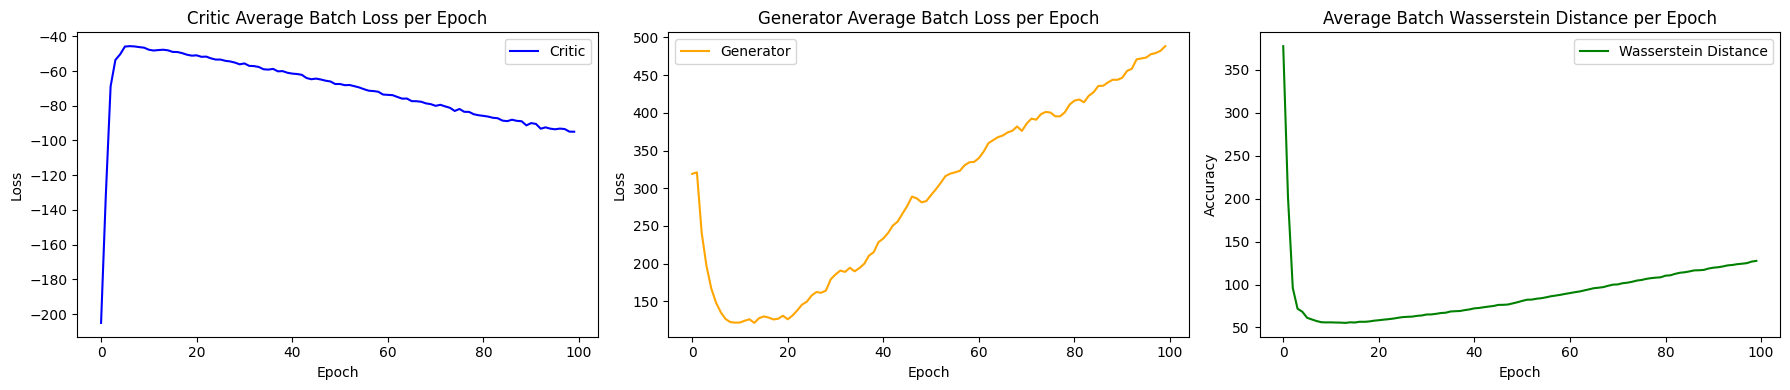

In [15]:

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 4))

# Plot Critic average loss
axs[0].plot(avg_loss_critic_epoch_list, label='Critic', color='blue')
axs[0].set_title("Critic Average Batch Loss per Epoch")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

# Plot Generator average loss
axs[1].plot(avg_loss_gen_epoch_list, label='Generator', color='orange')
axs[1].set_title("Generator Average Batch Loss per Epoch")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()


# Plot Discriminator average Wasserstein Distance
axs[2].plot(avg_wasserstein_distance_epoch_list, label='Wasserstein Distance', color='green')
axs[2].set_title("Average Batch Wasserstein Distance per Epoch")
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("Accuracy")
axs[2].legend()

# Adjust the layout so that the plots are not overlapping
plt.tight_layout()
plt.show()


## Save the Model

In [17]:
# save the model

torch.save(netC.state_dict(), os.path.join(image_dir, f'critic_epoch_100.pth'))
torch.save(netG.state_dict(), os.path.join(image_dir, f'generator_epoch_100.pth'))

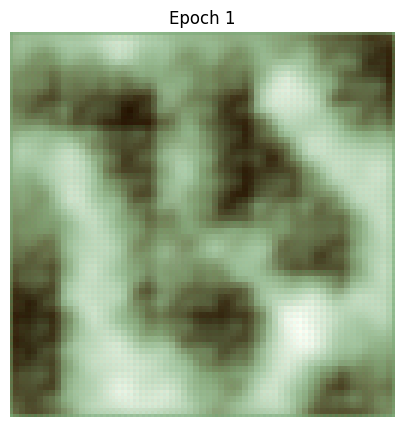

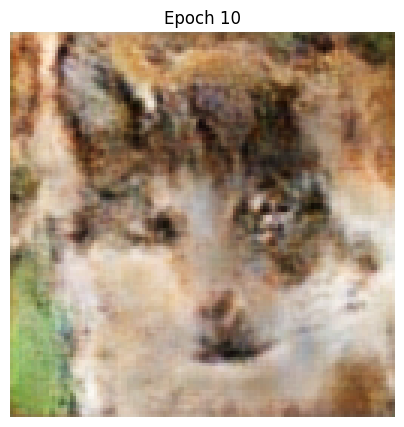

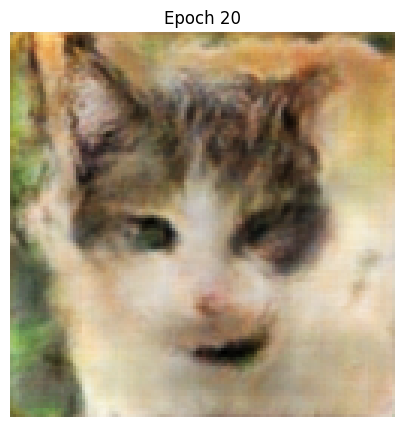

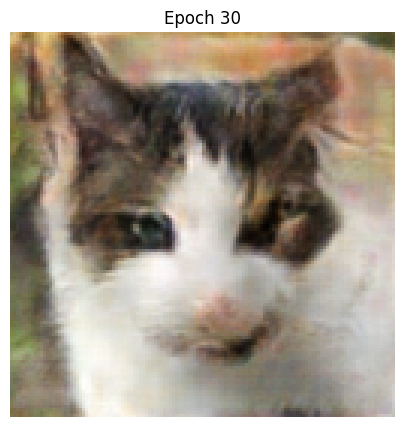

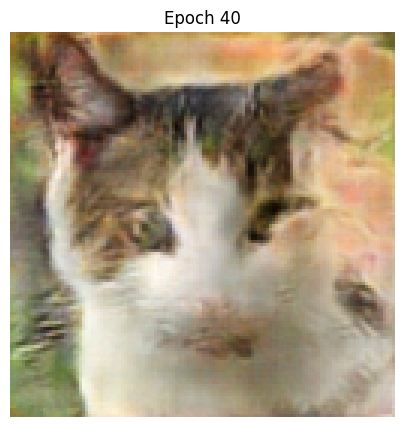

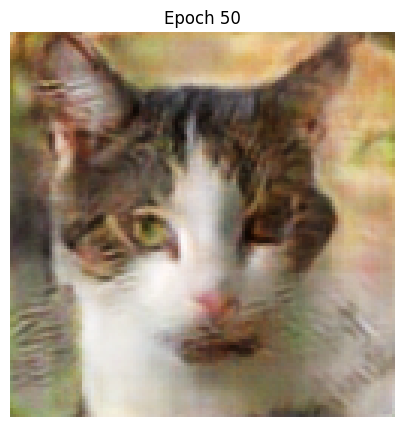

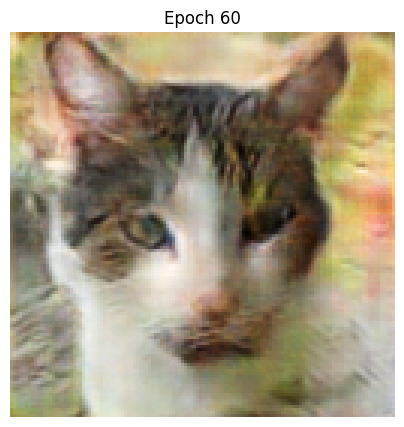

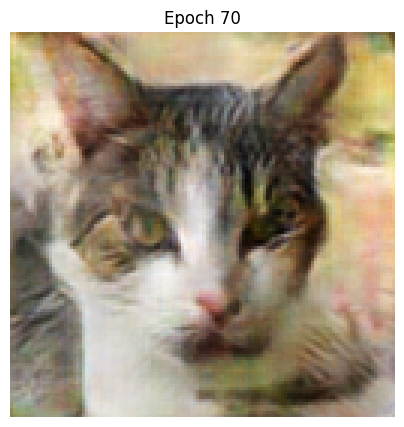

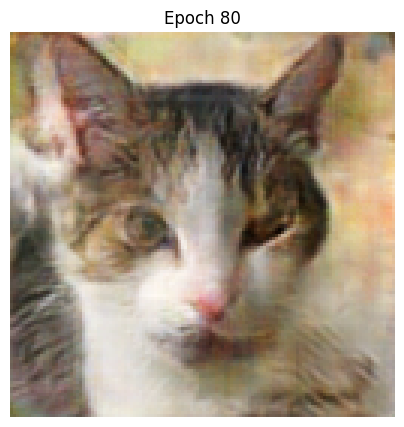

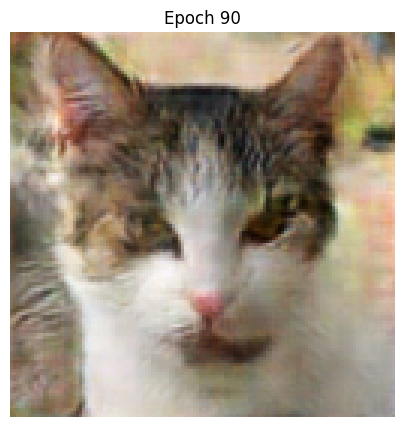

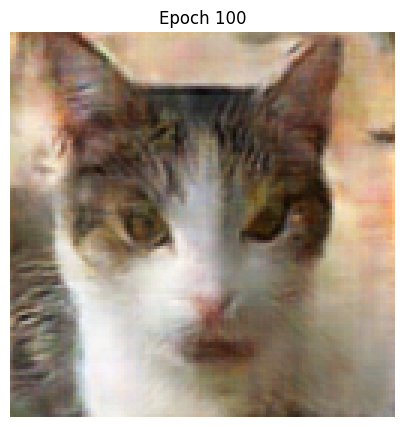

In [25]:


# Directory where the images are saved
image_dir = "wgan-gp_AFHQ_generated_images/single_images"



# Display the images
for epoch in range(0, NUM_EPOCHS + 1, 10):  # Start at epoch 1, end at NUM_EPOCHS, step by 10
    # Correctly format the filename with leading zeros up to four digits
    filename = f"single_fake_{epoch:04d}.png"
    filepath = os.path.join(image_dir, filename)
    
    # Check if the image file exists
    if os.path.exists(filepath):
        img = plt.imread(filepath)
        plt.figure(figsize=(5, 5))  # Adjust the size as needed
        plt.title(f"Epoch {epoch}")
        plt.imshow(img)
        plt.axis('off')  # Hide the axis
        plt.show()
    elif epoch == 0:
        filename = f"single_fake_{epoch+1:04d}.png"
        filepath = os.path.join(image_dir, filename)
        img = plt.imread(filepath)
        plt.figure(figsize=(5, 5))  # Adjust the size as needed
        plt.title(f"Epoch {epoch+1}")
        plt.imshow(img)
        plt.axis('off')  # Hide the axis
        plt.show()

    else:
        print(f"Image file {filename} does not exist.")


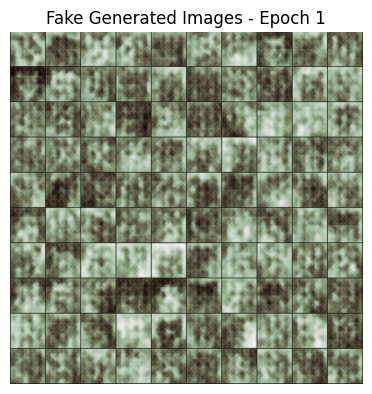

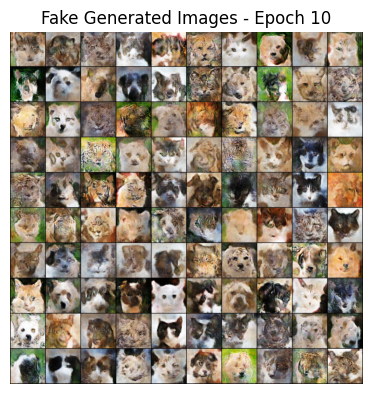

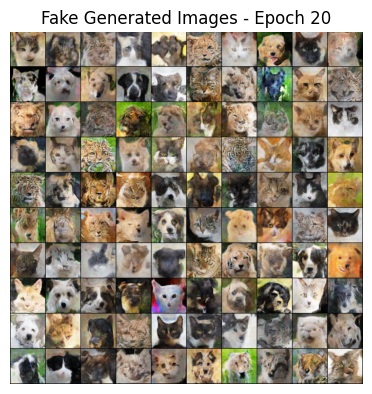

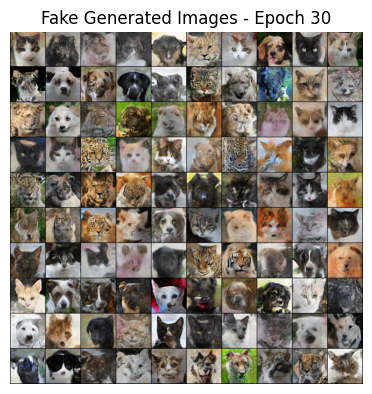

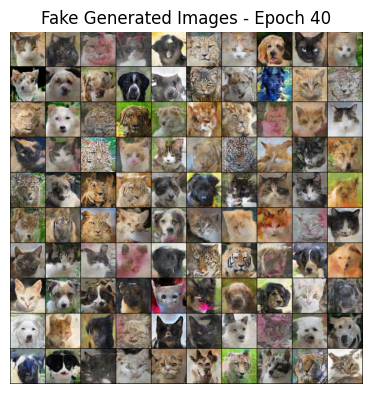

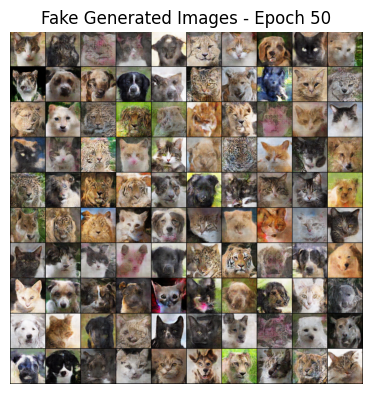

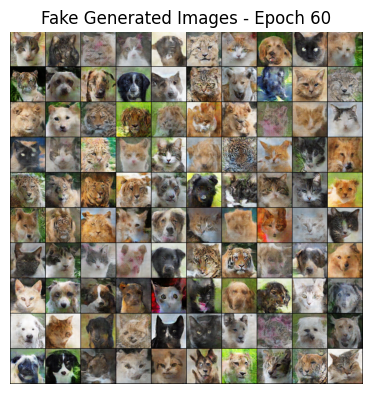

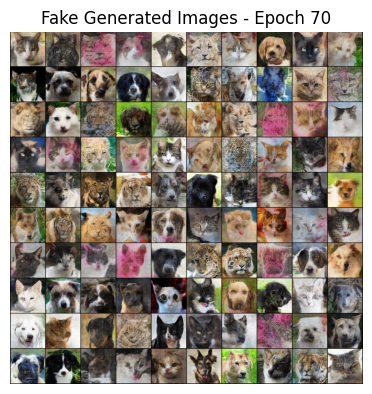

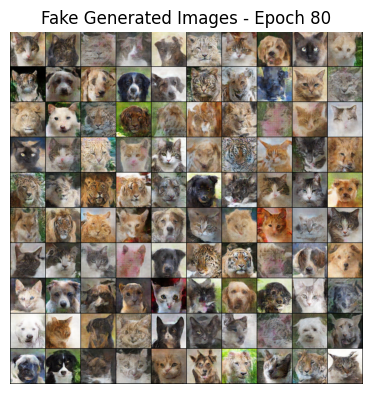

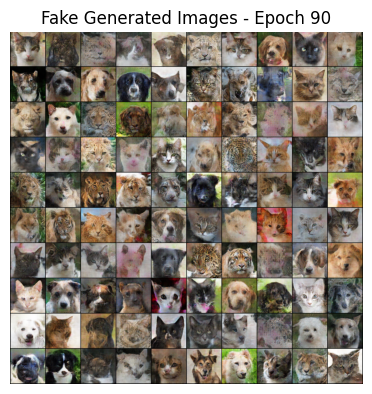

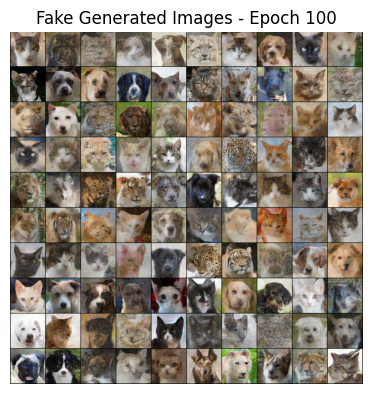

In [26]:

# Directory where the images are saved
image_dir = "wgan-gp_AFHQ_generated_images/multiple_images"

# Output images for every 10 epochs
for i in range(0, NUM_EPOCHS + 1 , 10):
    fake_filename = f"multiple_fake_{i:04d}.png"
    
    fake_filepath = os.path.join(image_dir, fake_filename)

    if os.path.exists(fake_filepath):
        fake_image = plt.imread(fake_filepath)

        plt.figure(figsize=(10, 10))
    

        # Plot fake images
        plt.subplot(1, 2, 2)
        plt.title(f"Fake Generated Images - Epoch {i}")
        plt.imshow(fake_image)
        plt.axis('off')

        plt.show()
        
    elif i == 0:
        fake_filename = f"multiple_fake_{i+1:04d}.png"
    
        fake_filepath = os.path.join(image_dir, fake_filename)
        fake_image = plt.imread(fake_filepath)
        plt.figure(figsize=(10, 10))

        # Plot fake images
        plt.subplot(1, 2, 2)
        plt.title(f"Fake Generated Images - Epoch {i+1}")
        plt.imshow(fake_image)
        plt.axis('off')

        plt.show() 
        
    else:
        print(f"Image files {fake_filename} or {real_filename} do not exist.")



## Compute Fréchet Inception Distance (FID) between 1000 Real and Fake images.

In [29]:
from torchvision.models import inception_v3

# Load pre-trained Inception v3 model
inception_model = inception_v3(pretrained=True, transform_input=False)
inception_model = inception_model.to(device)
inception_model.eval()  # Set to evaluation mode

# Function to get features from inception model

def get_inception_features(model, dataloader, device):
    model.eval()
    features = []
    with torch.no_grad():
        for batch in dataloader:
            imgs = batch[0]  # Assuming batch[0] contains images
            # Add a batch dimension if it's missing
            if imgs.dim() == 3:
                imgs = imgs.unsqueeze(0)
            imgs = imgs.to(device)
            # Make sure images are RGB
            if imgs.size(1) == 1:
                imgs = imgs.repeat(1, 3, 1, 1)  
            output = model(imgs)
            features.append(output)

    features = torch.cat(features, dim=0)
    return features



In [31]:
num_images_fid = 1000

# Function to create a dataloader of fake images
def create_fake_dataloader(generator, noise_dim, batch_size, device):
    noise = torch.randn(num_images_fid, noise_dim, 1, 1, device=device)
    fake_images = generator(noise).detach().cpu()
    fake_dataset = torch.utils.data.TensorDataset(fake_images)
    fake_loader = DataLoader(fake_dataset, batch_size=batch_size, shuffle=False)
    return fake_loader

# Create the dataloaders
# The batch size here is just for loading images; it does not affect the FID calculation.
real_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)  # val_dataset is a dataset of real images
fake_loader = create_fake_dataloader(netG, Z_DIM, 32, device)  # Replace netG with your trained generator model



# Get features from real and fake images
real_features = get_inception_features(inception_model, real_loader, device)
fake_features = get_inception_features(inception_model, fake_loader, device)



In [32]:
from scipy.linalg import sqrtm

# Function to calculate Frechet Inception Distance (FID)
def calculate_fid(real_features, fake_features):

    # Calculate the mean and covariance of real and fake images
    mu_real, sigma_real = real_features.cpu().mean(axis=0).numpy(), np.cov(real_features.cpu().numpy(), rowvar=False)
    mu_fake, sigma_fake = fake_features.cpu().mean(axis=0).numpy(), np.cov(fake_features.cpu().numpy(), rowvar=False)


    # Calculate the FID score
    ssdiff = np.sum((mu_real - mu_fake) ** 2.0) # sum of differences between the mean feature vectors
    covmean = sqrtm(sigma_real.dot(sigma_fake))  # covariance mean matrices of the real and fake images' feature distributions.

    # Check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma_real + sigma_fake - 2.0 * covmean)
    return fid

# Compute FID score
fid_score = calculate_fid(real_features, fake_features)
print(f'FID score: {fid_score}')


FID score: 3218.7062480495433


## Save the Model

In [33]:
model_save_path = "wgan-gp_AFHQ_trained_model"
os.makedirs(model_save_path, exist_ok=True)

torch.save(netC.state_dict(), os.path.join(model_save_path, f'critic_epoch_10.pth'))
torch.save(netG.state_dict(), os.path.join(model_save_path, f'generator_epoch_10.pth'))

## Plot the generated images obtained via linear interpolation of between a pair of latent vectors.

In [36]:

from collections import OrderedDict


def interpolate_points(p1, p2, alpha):
    return p1 + alpha * (p2 - p1)


def load_generator(filepath, noise_dim, channels_img, features_g):
    generator = Generator(noise_dim, channels_img, features_g)
    
    # Load state_dict from file
    state_dict = torch.load(filepath)
    
    # Adjust the keys
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] if k.startswith('module.') else k  # remove `module.` prefix
        new_state_dict[name] = v
    
    # Load the modified state_dict
    generator.load_state_dict(new_state_dict)
    
    generator.to(device)
    return generator


# Define a function to plot interpolated images
def plot_interpolated_images_without_labels(generator, latent_dim, device=device):

    # Sample two random latent vectors
    z1 = torch.randn(1, latent_dim, 1, 1).to(device)
    z2 = torch.randn(1, latent_dim, 1, 1).to(device)

    # Number of interpolation steps
    n_steps = 10
    interpolated_images = []

    # Interpolate between z1 and z2 and the corresponding labels
    for alpha in torch.linspace(0, 1, n_steps):
        z = interpolate_points(z1, z2, alpha)
        img = generator(z)
        img = (img - img.min()) / (img.max() - img.min())  # Normalize image
        interpolated_images.append(img)

    # Create a grid of images and plot
    grid = torchvision.utils.make_grid(torch.cat(interpolated_images, dim=0), nrow=n_steps)
    plt.figure(figsize=(15, 15))
    plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
    plt.axis('off')
    plt.title('Interpolation Between a pair of Generated Latents')  # Title for the plot
    plt.show()
    



# Load the trained generator
model_save_path = "wgan-gp_AFHQ_trained_model"
generator_path = os.path.join(model_save_path, 'generator_epoch_10.pth')
generator = load_generator(generator_path, Z_DIM, CHANNELS_IMG, FEATURES_GEN)




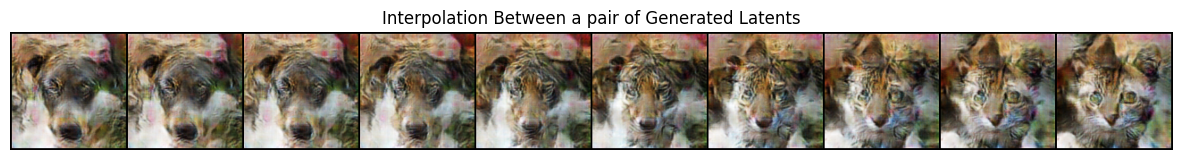

In [43]:
# Plot interpolation
plot_interpolated_images_without_labels(netG, Z_DIM, device)

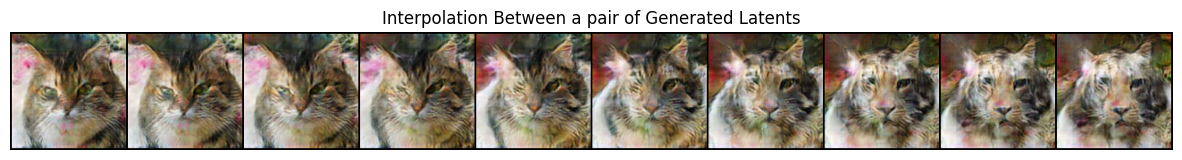

In [39]:
# Plot interpolation
plot_interpolated_images_without_labels(netG, Z_DIM, device)
